In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random

# Sampling from gaussian distribution

In [2]:
mu_centered, sigma_centered = 0, 0.1
s_normal_centered = np.random.normal(mu_centered, sigma_centered, 1000)

mu_shifted, sigma_shifted = 10, 0.2
s_normal_shifted = np.random.normal(mu_shifted, sigma_shifted, 1000)

μ_centered =0.0031915488312922093
σ_centered =0.0995767956468509
μ_shifted =9.999080337426971
σ_shifted =0.20620049594181172


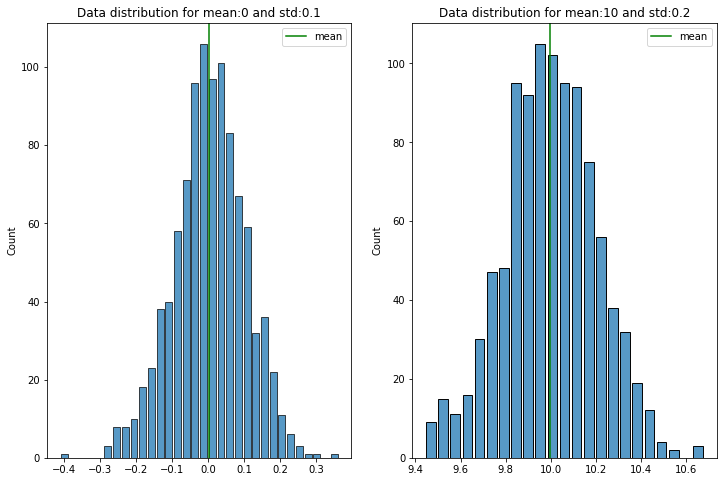

In [3]:
fig, axis = plt.subplots(1,2,figsize=(12,8))

sns.histplot(s_normal_centered, ax=axis[0], shrink=0.8, stat='count').set(title=f"Data distribution for mean:{mu_centered} and std:{sigma_centered}")
axis[0].axvline(s_normal_centered.mean(), color='green', label='mean')
axis[0].legend()

sns.histplot(s_normal_shifted, ax=axis[1], shrink=0.8, stat='count').set(title=f"Data distribution for mean:{mu_shifted} and std:{sigma_shifted}")
axis[1].axvline(s_normal_shifted.mean(), color='green', label='mean')
axis[1].legend()

print(f'μ_centered ={s_normal_centered.mean()}')
print(f'σ_centered ={s_normal_centered.std()}')
print(f'μ_shifted ={s_normal_shifted.mean()}')
print(f'σ_shifted ={s_normal_shifted.std()}')


# Data sets generation

In [16]:
# sample 90% from centered dataset
centered_dist = random.sample(list(s_normal_centered), 900)
normal_points = ["no" for e in centered_dist]

# sample 1% from shifted dataset 
shifted_dist = random.sample(list(s_normal_shifted), 100)
outliers = ["yes" for e in shifted_dist]

numbers = centered_dist + shifted_dist 
labels = normal_points + outliers 

# Create df with two columns (number, label)
df = pd.DataFrame({'number': numbers, 'label_gt': labels})
df["numeric_label_gt"] = np.where(df['label_gt']== "yes", -1, 1)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   number            1000 non-null   float64
 1   label_gt          1000 non-null   object 
 2   numeric_label_gt  1000 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 23.6+ KB


In [18]:
df.head()

,number,label_gt,numeric_label_gt
0,-0.034286,no,1
1,0.112082,no,1
2,-0.021964,no,1
3,-0.136562,no,1
4,0.133835,no,1


In [19]:
df.tail()

,number,label_gt,numeric_label_gt
995,10.022612,yes,-1
996,9.983941,yes,-1
997,10.087726,yes,-1
998,10.426114,yes,-1
999,9.892616,yes,-1


In [20]:
df.describe()

,number,numeric_label_gt
count,1000.000000,1000.0000
mean,1.004847,0.8000
std,3.004654,0.6003
min,-0.411074,-1.0000
25%,-0.046547,1.0000
50%,0.019733,1.0000
75%,0.098570,1.0000
max,10.567363,1.0000


In [21]:
# The frac keyword argument specifies the fraction of rows to return in the random sample, 
# so frac=1 means to return all rows (in random order
df = df.sample(frac=1)

# Isolation Forest

In [45]:
# Train IF, K-means, RF, SVDD? 
from sklearn.ensemble import IsolationForest

model=IsolationForest(n_estimators=50, max_samples='auto', contamination=0.1,max_features=1.0)
model.fit(df[['number']])

IsolationForest(contamination=0.1, n_estimators=50)

In [47]:
df['scores']=model.decision_function(df[['number']])

df['anomaly']=model.predict(df[['number']])

df["anomaly"] = np.where(df['anomaly']== -1, "yes", "no")

print(df['anomaly'].value_counts())

(df["anomaly"] == df["label_gt"]).value_counts()


no     900
yes    100
Name: anomaly, dtype: int64


True     936
False     64
dtype: int64

## Using Grid Search to find the best set of parameters for IF

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

my_scoring_func = make_scorer(f1_score)
parameters = {'n_estimators':[10,30,50,80,100], 
            'max_features':[0.1,0.2,0.3,0.4,1.0], 
            'contamination' : [0.1,0.2]
            }
isolation_forest =  IsolationForest(max_samples='auto')
search = GridSearchCV(isolation_forest, parameters,  scoring=my_scoring_func)
search.fit(df[['number']], df[['numeric_label_gt']])

GridSearchCV(estimator=IsolationForest(),
             param_grid={'contamination': [0.1, 0.2],
                         'max_features': [0.1, 0.2, 0.3, 0.4, 1.0],
                         'n_estimators': [10, 30, 50, 80, 100]},
             scoring=make_scorer(f1_score))

In [75]:
result_search_df = pd.DataFrame(search.cv_results_)
best_estimators = result_search_df[["mean_test_score", "std_test_score", "params"]].sort_values(by=["mean_test_score"], ascending=False).head()
print(f"Best estimator parameters: {best_estimators.iloc[0]['params']}")

Best estimator parameters: {'contamination': 0.1, 'max_features': 0.1, 'n_estimators': 100}


In [73]:
optimal_forest = search.best_estimator_
pred = optimal_forest.predict(df[['number']])

h = (pred == df['numeric_label_gt']).value_counts()

54

In [71]:
# Visualize results
df

,number,label_gt,numeric_label_gt,scores,anomaly
712,0.042515,no,1,0.183291,no
72,-0.002482,no,1,0.192805,no
646,0.012873,no,1,0.182723,no
985,9.931699,yes,-1,0.002049,no
873,-0.192749,no,1,0.028478,no
...,...,...,...,...,...
418,-0.193279,no,1,0.022917,no
412,0.045927,no,1,0.177560,no
55,-0.063944,no,1,0.156472,no
842,0.032367,no,1,0.194308,no
